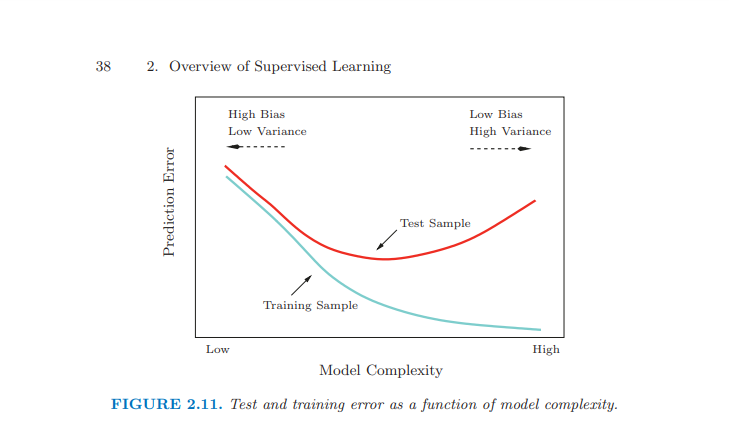

In [2]:
# Bias-variance trade-off and resampling techniques.
# bias-variance analysis of Franke function, Study MSE for different polynomial degrees.

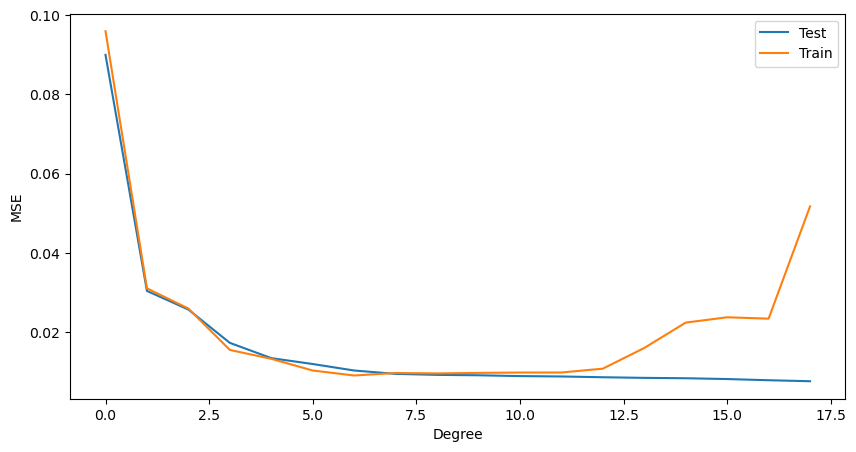

In [3]:
# Re-create this illustration from Hastie et.al
# some moc-up data.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from script import FrankeFunction

np.random.seed(42)
degree = range(18)
n = 1000
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
noise = 0.1*np.random.normal(0, 1, n)
Z = FrankeFunction(x, y) + noise

scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_scaled = scaler_x.fit_transform(x.reshape(-1,1))
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))

x_combined = np.hstack((x_scaled, y_scaled))

# Split the data into training and test data
x_train, x_test, z_train, z_test = train_test_split(x_combined, Z, test_size=0.2)

mse_ols = []
mse_ols_test = []


for deg in degree:
  poly = PolynomialFeatures(degree=deg)
  
  X_train_poly = poly.fit_transform(x_train)
  X_test_poly = poly.transform(x_test)
  
  beta_OLS = np.linalg.inv(X_train_poly.T @ X_train_poly) @ X_train_poly.T @ z_train
  
  y_pred_OLS = X_train_poly @ beta_OLS
  
  mse = mean_squared_error(z_train, y_pred_OLS)
  mse_ols.append(mse)

  y_pred_OLS_test = X_test_poly @ beta_OLS

  mse_ols_test.append( mean_squared_error(z_test, y_pred_OLS_test))


plt.figure(figsize=(10,5))
plt.plot(degree, mse_ols, label='Test')
plt.plot(degree, mse_ols_test, label='Train')
plt.xlabel('Degree')
plt.ylabel('MSE') 
plt.legend()
plt.show()


Error:  0.09104743134426854
Bias^2: 0.02067347410558682
Var: 0.07037395723868173
0.09104743134426854 >= 0.02067347410558682 + 0.07037395723868173 = 0.09104743134426854


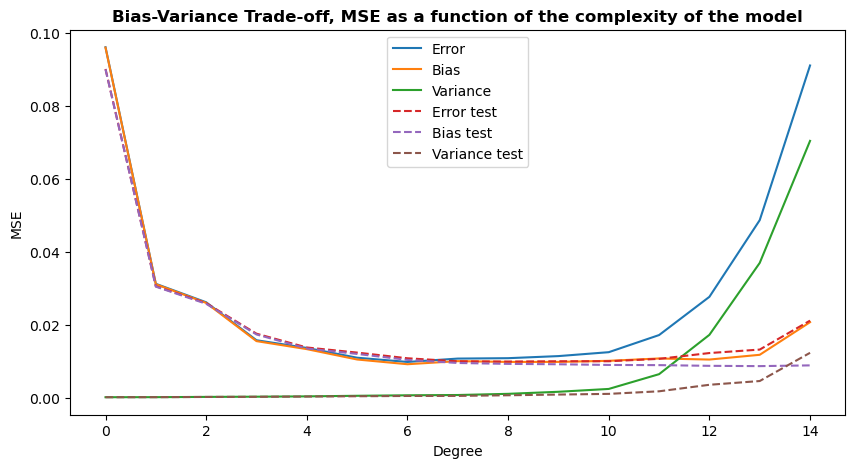

In [9]:
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

n_bootstraps = 100

maxdegree = 15
mse_list, bias_list, variance_list = [], [], []
mse_test_list, bias_test_list, variance_test_list = [], [], []

polyDegree = np.zeros(maxdegree)

for degree in range(maxdegree):
  model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))
  z_pred_test = np.empty((z_test.shape[0], n_bootstraps))
  z_pred_train = np.empty((z_train.shape[0], n_bootstraps))

  for i in range(n_bootstraps):
    x_ , z_ = resample(x_train, z_train)
    model.fit(x_, z_)

    z_pred_test[:,i] = model.predict(x_test).ravel()
    z_pred_train[:,i] = model.predict(x_train).ravel()

  polyDegree[degree] = degree
  
  error_train = np.mean(np.mean((np.expand_dims(z_train, axis=1) - z_pred_train)**2, axis=1, keepdims=True))
  bias_train = np.mean((np.expand_dims(z_train, axis=1) - np.mean(z_pred_train, axis=1, keepdims=True))**2)
  variance_train = np.mean(np.var(z_pred_train, axis=1, keepdims=True))
  
  error = np.mean(np.mean((np.expand_dims(z_test, axis=1) - z_pred_test)**2, axis=1, keepdims=True))
  bias = np.mean((np.expand_dims(z_test, axis=1) - np.mean(z_pred_test, axis=1, keepdims=True))**2)
  variance = np.mean(np.var(z_pred_test, axis=1, keepdims=True))

  mse_list.append(error)
  bias_list.append(bias)
  variance_list.append(variance)

  mse_test_list.append(error_train)
  bias_test_list.append(bias_train)
  variance_test_list.append(variance_train)


print("Error: ", error)
print('Bias^2:', bias)
print('Var:', variance)
print('{} >= {} + {} = {}'.format(error, bias, variance, bias+variance))

plt.figure(figsize=(10,5))
plt.plot(polyDegree, mse_list, label='Error')
plt.plot(polyDegree, bias_list, label='Bias')
plt.plot(polyDegree, variance_list, label='Variance')

plt.plot(polyDegree, mse_test_list, linestyle="--", label='Error test')
plt.plot(polyDegree, bias_test_list, linestyle="--", label='Bias test')
plt.plot(polyDegree, variance_test_list, linestyle="--", label='Variance test')
plt.title('Bias-Variance Trade-off, MSE as a function of the complexity of the model', fontweight='bold')
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.legend()
plt.show()
